## **Customer Segmentation**

In [16]:
# Data handling
import numpy as np
import pandas as pd

# Data warehousing 
from sqlalchemy import create_engine
import pyodbc
import urllib

# Exploratory Data Analysis & Visualisation 
%matplotlib inline
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

# Model improvement and Evaluation 
from sklearn.cluster import KMeans

#### **----------------------------------  1. Data collection  -----------------------------------**

In [17]:
# Importing data through API 
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python -p ..\Data --unzip 


  0%|          | 0.00/1.55k [00:00<?, ?B/s]
100%|██████████| 1.55k/1.55k [00:00<00:00, 1.61MB/s]


In [18]:
# Reading data into dataframe 
data = pd.read_csv('../Data/Mall_Customers.csv')

#### **----------------------------------  2. Data pre-processing  -----------------------------------**

In [19]:
# Viewing first 5 rows of data
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [20]:
# Viewing the data types of the columns
data.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [21]:
# Viewing dataset shape
data.shape

(200, 5)

In [22]:
# 1st check for null values and datatype check 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [23]:
# 2nd check for number of null values
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [24]:
# Unique count for each variable
data.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

In [25]:
# Viewing summary of statistics for numeric columns
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [26]:
# (SQL standard) Formatting column headers by removing potential capital letters and spaces in column headers 
data.columns = data.columns.str.lower()
data.columns = data.columns.str.replace(' ','_')

#### **----------------------------------  3. Data Warehousing  -----------------------------------**

In [27]:
# Saving cleaned data as csv
data.to_csv('../Data/customer_seg_clean.csv', index=False)

In [28]:
def ETL_SQLServer(Server,db,tablename):
  """
    :param Server: Destination Server
    :param db: Destination Database name MUST ALREADY EXIST
    :param tablename: Project ID and Dataset name
    """

  # SQL table header format
  tablename = tablename.lower()
  tablename = tablename.replace(' ','_')

  quoted = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=%s;DATABASE=%s"%(Server,db))
  engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

  data.to_sql('{tb}'.format(tb=tablename), schema='dbo', con = engine, index=False, if_exists='replace')

  return("ETL successful, {num} rows loaded into table: {tb}.".format(num=len(data.iloc[:,0]), tb=tablename))

In [14]:
# Calling function from custom functions to warehouse dataframe
ETL_SQLServer("DESKTOP-I9HIN85","Projects","P13 Customer Segmenetation")

'ETL successful, 200 rows loaded into table: p13_customer_segmenetation.'

#### **----------------------------------  4. Exploratory data analysis  -----------------------------------**

In [ ]:
# Checking distribution of categorical fields 
# print(data.outcome.value_counts())
# print(data.pregnancies.value_counts())

In [29]:
# Viewing summary of statistics for numeric columns
data.describe()

,customerid,age,annual_income_(k$),spending_score_(1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


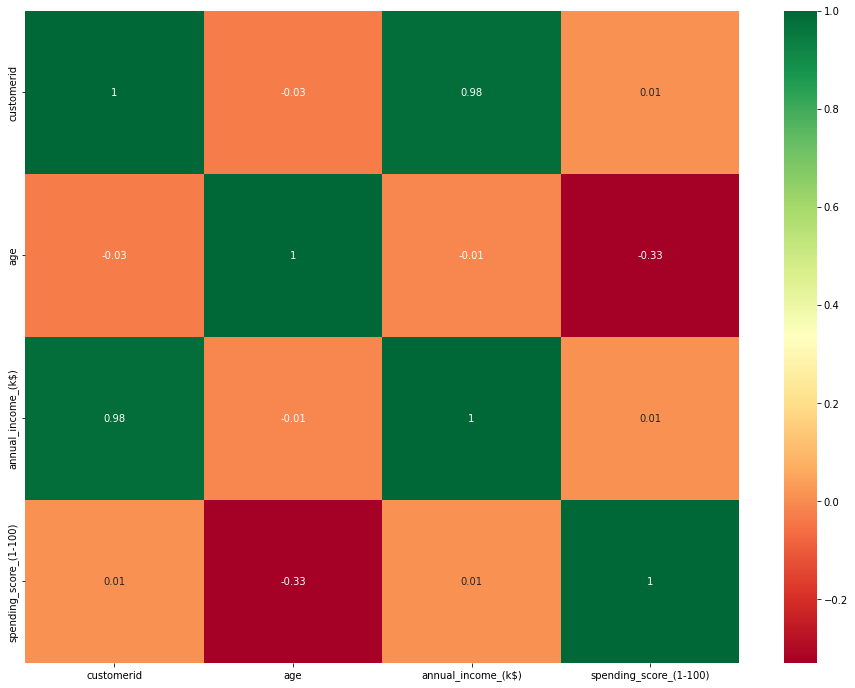

In [31]:
# Viewing correlations of each features in dataset 
datacorr = round(data.corr(),2)
corrmat = datacorr
top_corr_features = corrmat.index
plt.figure(figsize=(16,12),facecolor='white')

# Plotting heat map
plot = sns.heatmap(datacorr,annot=True,cmap="RdYlGn")
plt.savefig('../images/customer_seg_correlation.png')

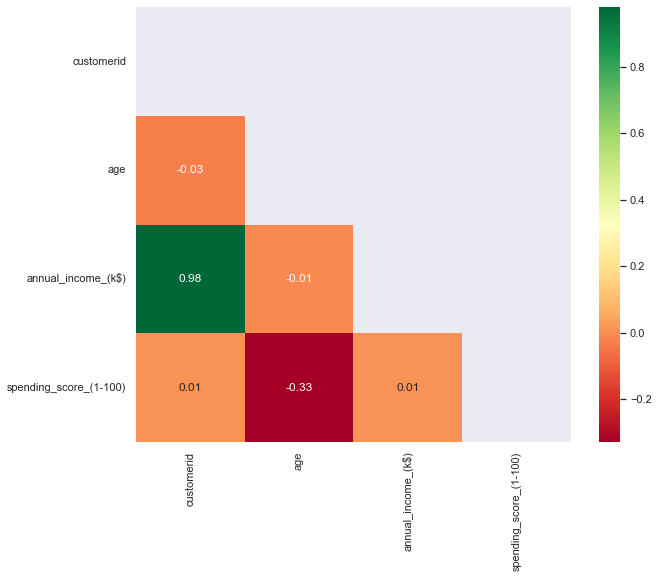

In [40]:
mask = np.zeros_like(datacorr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(datacorr, mask=mask, square=True, cmap='RdYlGn', annot=True);

In [32]:
# Profile report of each variable
pandas_profiling.ProfileReport(data)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


#### **----------------------------------  5. Feature engineering  -----------------------------------**

In [33]:
# Grouping columns that will be used for clustering (Annual Income & Spending score column)
X = data.iloc[:,[3,4]].values

<img src="../images/WSS_formula.png"/>

In [35]:
# Chosing the optimum number of clusters 
# Finding wcss(within clusters sum of squares) value for different number of clusters

wcss = []

# For loop to find optimum number of clusters 
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=23)
  kmeans.fit(X)

  wcss.append(kmeans.inertia_)

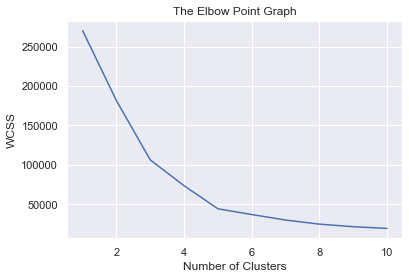

In [36]:
# plot an elbow graph

sns.set()
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [37]:
# Training the k-Means Clustering Model
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)

# return a label for each data point based on their cluster
Y = kmeans.fit_predict(X)

print(Y)

[4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 1 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 1 2 0 2 0 2 1 2 0 2 0 2 0 2 0 2 1 2 0 2 0 2
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2]


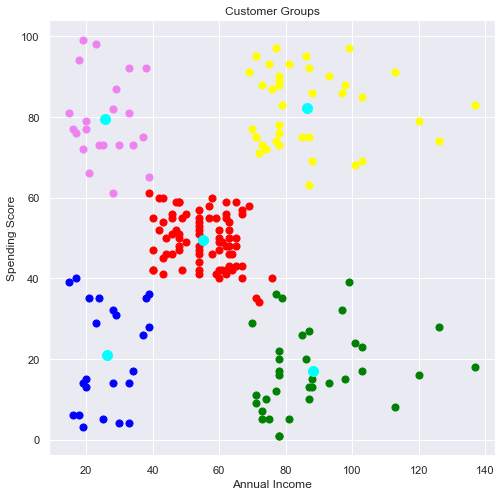

In [38]:
# 5 Clusters - 0, 1, 2, 3, 4
# plotting all the clusters and their Centroids

plt.figure(figsize=(8,8))
plt.scatter(X[Y==0,0], X[Y==0,1], s=50, c='green', label='Cluster 1')
plt.scatter(X[Y==1,0], X[Y==1,1], s=50, c='red', label='Cluster 2')
plt.scatter(X[Y==2,0], X[Y==2,1], s=50, c='yellow', label='Cluster 3')
plt.scatter(X[Y==3,0], X[Y==3,1], s=50, c='violet', label='Cluster 4')
plt.scatter(X[Y==4,0], X[Y==4,1], s=50, c='blue', label='Cluster 5')

# plot the centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='cyan', label='Centroids')

plt.title('Customer Groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()